# DTSA-5511:  Week 3 - Kaggle Mini Project
### September 13, 2022


## Histopathologic Cancer Detection using Convolutional Neural Networks
### Introduction

This is the Week 3 assignment for DTSA-5511, Introduction to Deep Learning.  This project applies convolutional neural networks (CNN) to a image dataset in an attempt to identify metastatic cancer in small image patches taken from larger digital pathology scans. The image dataset comes from a 2019 [Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection) and although the competition has closed that dataset is still available for research and experimentation purposes. 

Before detailing the techniques and methods used to create and train the CNN, some definitions and background information may be useful for non-medical professionals. A "metastatic cancer" occurs when cancer cells break off from the original tumor, enter your bloodstream or lymph system and spread to other areas of your body$^1$ and histopathology is the study of diseased cells and tissues using a microscope.$^2$ 

From these definitions, we can tell the image dataset is comprised of small picture of tissue samples which have been classifed as either containing cancer cells or not, positive and negative respectively. The images themselves were captured using a microsope and the tissue samples are stained to ease the ability of a pathologist, a specialist doctor who examines tissue under a microscope, to observe and document the sample's details. This is a very specialized task and as a single cell can be missed, also difficult and time consuming.  

The goal of this project is to see whether a CNN can be trained to perform this specialized task.

Finally, this Jupyter notebook can be downloaded from https://github.com/clayv/DTSA-5511_Week3.

**References:**  
$^1$Cleveland Clinic. Metastasis (Metastatic Cancer). 
https://my.clevelandclinic.org/health/diseases/22213-metastasis-metastatic-cancer  
$^2$National Cancer Institute. NCI dictionary of cancer terms. 
https://my.clevelandclinic.org/health/diseases/22213-metastasis-metastatic-cancer  

### The Dataset
The dataset is essentially comprised of 2 sections, a set of 96 pixel by 96 pixel images stored in the Tagged Image File Format (TIFF) and a Comma Separated Value (CSV) text file which indicates whether a given image has at least 1 pixel of tumor tissue in the center 32 pixel by 32 pixel patch of the image. The outer ring of the image which surrounds the this center patch does not influence whether the image is labeled positive or negative.

The images are further broken into 2 groups, a training set comprised of 220,025 images and a testing set with 57,458 and the CSV file only provides labels for the training set. Of the 220,025 training images, 130,908 are labeled as negative and 89,117 as positive.  Although this is not fully balanced with a negative to postive ratio of 1.47:1, the ratio was not so far from 1:1 that I felt that balancing the dataset would be necessary.

A display of both positive and negative sample images follows below.

In [148]:
import cv2
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Activation, Conv2D, Dense, Dropout
from keras.layers import Flatten, MaxPooling2D, Rescaling
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import tensorflow as tf


In [2]:
print("Keras version:",keras.__version__)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Keras version: 2.10.0
Mon Sep 12 08:30:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8     8W / 130W |    417MiB /  6144MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                  

In [3]:
#Globals
dirDLBase = "./KaggleDownload"
dirDLTrainBase = os.path.join(dirDLBase, "train")
dirDLTestBase =  os.path.join(dirDLBase, "test")
dirModelTrain = "./Training"

positive = "Positive"
negative = "Negative"

imgWidth = 96
imgHeight = 96

randomState = 42

recreateTrainDir = False

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

dfTrainLabels = pd.read_csv(os.path.join(dirDLBase, "train_labels.csv"))

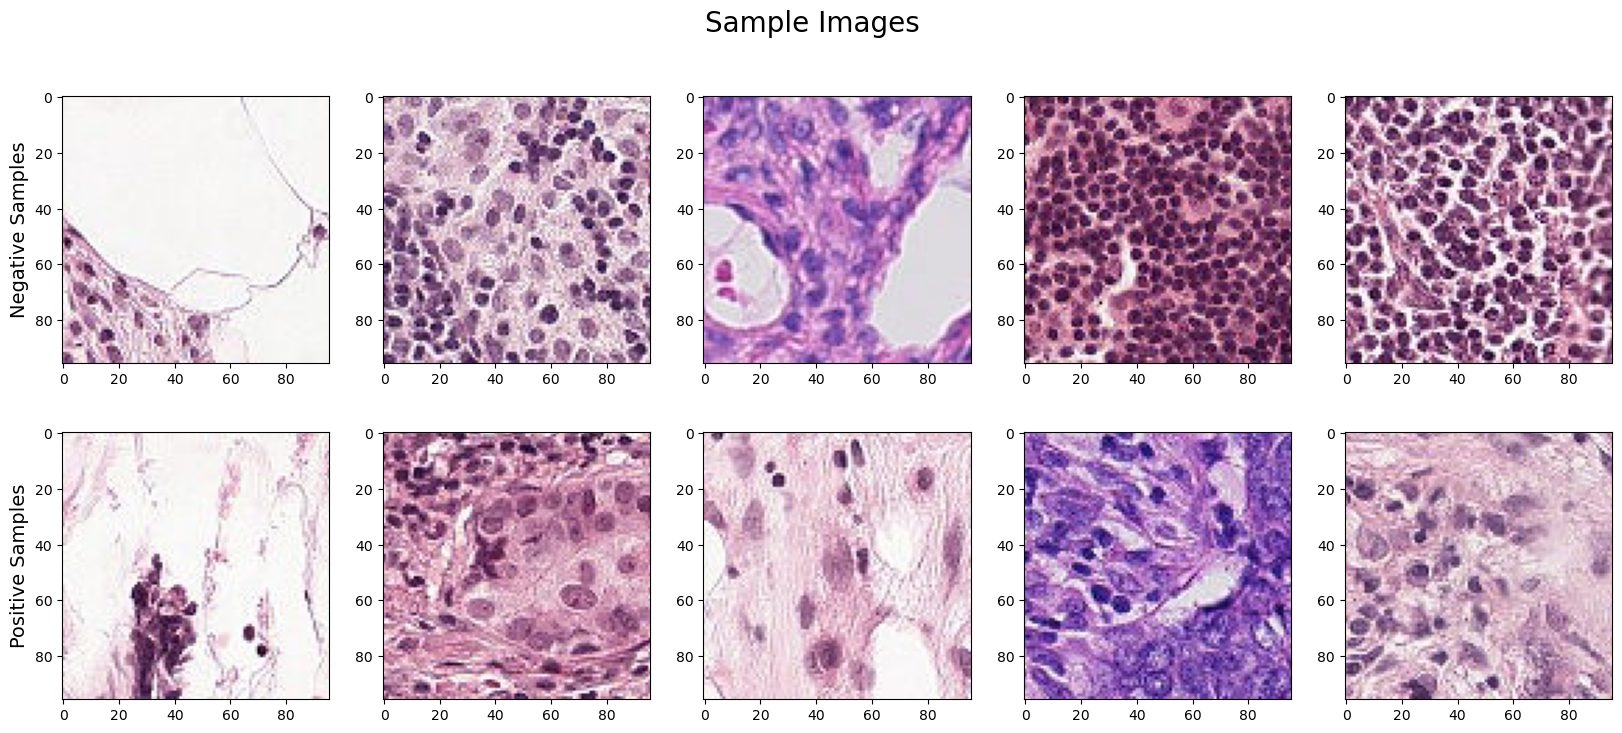

In [182]:
def makeSampleRow(row):
    for i, imageId in enumerate(dfTrainLabels[dfTrainLabels['label'] == row]['id'][:5]):
        path = os.path.join(dirDLTrainBase, imageId)
        b, g, r = cv2.split(cv2.imread(path + '.tif', cv2.IMREAD_UNCHANGED))
        ax[row, i].imshow(cv2.merge([r, g, b]))

fig, ax = plt.subplots(2, 5, figsize = (20, 8))
fig.suptitle('Sample Images', fontsize = 20)

makeSampleRow(0)
makeSampleRow(1)
ax[0, 0].set_ylabel('Negative Samples', fontsize='14')
ax[1, 0].set_ylabel('Positive Samples',  fontsize='14')

plt.show()

### Data Wrangling
This is a curated dataset, so no traditional data wrangling is required. However, the [Keras](https://keras.io/) API [image_dataset_from_directory](https://keras.io/api/preprocessing/image/) does not work with TIFF images and one way of working with the API requires that the classes the images fall into be in separate directories.  The code below creates the necessary directory structure, converts the TIFF images to 256 bit Bitmap (BMP) files, and places the converted images into the appropriate directory (the "augmentImages" function will be detailed later in this notebook).

In [4]:
def makeDirectory(directory):
    try:
        os.mkdir(directory)
    except:
        pass
    
def createTrainDirStructure(directory, createNew):
    if createNew:
        try:
            !rmdir /s /q "./Training"
            makeDirectory(directory)
        except:
            pass

    dirPositive = os.path.join(directory, positive)
    dirNegative = os.path.join(directory, negative)
    
    if createNew:
        makeDirectory(dirPositive)
        makeDirectory(dirNegative)
        
    return dirPositive, dirNegative

def augmentImages(path):
    brightnessFactor = 16
    contrastFactor = 10
    
    for (dirpath, dirnames, filenames) in os.walk(path):
        fileListGen = (f for f in filenames)
    fileList = list(fileListGen)
    for file in fileList:
        fullPath =  os.path.join(path, file)

        image = cv2.imread(fullPath, cv2.IMREAD_UNCHANGED)
        
        for i in range(4):
            #Rotation
            rotation = random.randint(-1, 1) * 90
            rotMatrix = cv2.getRotationMatrix2D((imgWidth >> 1, imgHeight >> 1), rotation, 1)
            augImage = cv2.warpAffine(image, rotMatrix, (imgWidth, imgHeight))

            #Randomly horizontally flip
            if( bool(random.getrandbits(1))):
                augImage = augImage[:, ::-1]
            #Randomly vertically flip
            if(bool(random.getrandbits(1))):
                augImage = augImage[::-1, :]

            #Random brightness
            brightness = random.randint(-brightnessFactor, brightnessFactor)
            augImage = (augImage + brightness)

            #Random contrast
            contrast = 1.0 + random.randint(-contrastFactor, contrastFactor) / 100
            augImage = (augImage * contrast).astype(int)

            #Ensure valid values
            augImage = np.clip(augImage, 0, 255)
    
            cv2.imwrite(os.path.join(path, str(i) + "P_" + file), augImage)

dirModelTrainPositive, dirModelTrainNegative = createTrainDirStructure(dirModelTrain, recreateTrainDir)
if recreateTrainDir:
    for row in dfTrainLabels.itertuples():
        image = cv2.imread(os.path.join(dirDLTrainBase, row.id + ".tif"), cv2.IMREAD_UNCHANGED)
        destFileName = row.id + ".bmp"
        if row.label == 0:
            cv2.imwrite(os.path.join(dirModelTrainNegative, destFileName), image)
        else:
            cv2.imwrite(os.path.join(dirModelTrainPositive, destFileName), image)


### Plotting Training Results
The following cell contains the code to plot the training results of the various models trained in this notebook

In [168]:
def plotTrainingResults(history, actuals, predictions, dataName):
    fig, ax = plt.subplots(2, 2, figsize=(13, 10))
    
    upper = len(history['loss']) + 1

    ax[0, 0].plot(np.arange(1, upper), history['loss'], label = 'Training')
    ax[0, 0].plot(np.arange(1, upper), history['val_loss'], label = 'Validation', color = 'red')
    ax[0, 0].set(xticks=np.arange(2, upper, 2))
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].set_title("Loss w/" + dataName)
    ax[0, 0].legend()

    ax[0, 1].plot(np.arange(1, upper), history['accuracy'], label = 'Training')
    ax[0, 1].plot(np.arange(1, upper), history['val_accuracy'], label = 'Validation', color = 'red')
    ax[0, 1].set(xticks=np.arange(2, upper, 2))
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_title("Accuracy w/" + dataName)
    ax[0, 1].legend()

    fpr, tpr, threshold = roc_curve(actuals, predictions)
    ax[1, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % history['val_auc'][-1])
    ax[1, 0].set_xlabel('False Positive Rate')
    ax[1, 0].set_ylabel('True Positive Rate')
    ax[1, 0].set_title(dataName + " ROC")
    ax[1, 0].legend(loc="lower right")
    
    cm = confusion_matrix(actuals, np.where(predictions < .5, 0, 1))

    ax[1, 1].matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[1, 1].text(x = j, y = i, s = cm[i, j], va='center', ha='center', size='xx-large')
    ax[1, 1].set_xlabel("Confusion Matrix on\n" + dataName + "\n(0 = Negative, 1 = Positive)", fontsize = 14)
    ax[1, 1].set_ylabel('Actuals', fontsize = 12)
    ax[1, 1].set_title('Predictions', fontsize = 12)    

    plt.subplots_adjust(hspace = 0.4)
    plt.show()

### Model Definition and Training
Because no labels were provided for the testing set of images, in all the models trained below 10% of the training set of images were held out to use for validating a model's training. So of the provided 220,025 images in training set, 22,002 were held back for validation and the remaining 198,023 images were used to train the model.

My initial approach for creating a model was to try something very atypical and essentially ignored the guidance proposed in the lecture. This turned out to be a disaster and this architecture was thrown away after several hours spent attempting to make it work.

After those experiments, I eventually landed with a more traditional neural network consisting of:  
Input -> (3 x (Convolution -> Convolution -> Convolution -> MaxPool -> Dropout)) -> Flatten -> Dense -> Dropout -> Dense -> Output  
with a final trainable parameter count of 1,660,929.

This model trained well in 20 epochs, with the final results on the validation images being:  
**Accuracy**: 0.8841  
**Precision**: 0.7990  
**Recall**: 0.9534  
**Area Under ROC Curve**: 0.9710  

The model setup and training are in the next 2 cells.

In [5]:
#Training setup and model definition
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 2, 
                              verbose = 1, mode = 'max', min_lr = 0.000001)
earlyStop = EarlyStopping(monitor='loss', patience = 3)
callbacks_list = [reduce_lr, earlyStop]

def buildStandardModel(batchSize):
    kernelSize = (3, 3)
    poolSize= (2, 2)
    layer1FilterCount = 32
    layer2FilterCount = 64
    layer3FilterCount = 128
    convolutionDropRate = 0.3
    denseDropRate = 0.3

    model = Sequential()
    model.add(Rescaling(1./255))

    model.add(Conv2D(layer1FilterCount, kernelSize, activation = 'relu', padding = "valid"))
    model.add(Conv2D(layer1FilterCount, kernelSize, activation = 'relu', padding = "valid"))
    model.add(Conv2D(layer1FilterCount, kernelSize, activation = 'relu', padding = "valid"))
    model.add(MaxPooling2D(pool_size = poolSize))
    model.add(Dropout(convolutionDropRate))

    model.add(Conv2D(layer2FilterCount, kernelSize, activation ='relu', padding = "valid"))
    model.add(Conv2D(layer2FilterCount, kernelSize, activation ='relu', padding = "valid"))
    model.add(Conv2D(layer2FilterCount, kernelSize, activation ='relu', padding = "valid"))
    model.add(MaxPooling2D(pool_size = poolSize))
    model.add(Dropout(convolutionDropRate))

    model.add(Conv2D(layer3FilterCount, kernelSize, activation ='relu', padding = "valid"))
    model.add(Conv2D(layer3FilterCount, kernelSize, activation ='relu', padding = "valid"))
    model.add(Conv2D(layer3FilterCount, kernelSize, activation ='relu', padding = "valid"))
    model.add(MaxPooling2D(pool_size = poolSize))
    model.add(Dropout(convolutionDropRate))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(denseDropRate))
    model.add(Dense(1, activation = "sigmoid"))

    input_shape = (batchSize, imgHeight, imgWidth, 3)
    model.build(input_shape)

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
                  loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                  metrics = METRICS)
    
    tfdsTrain, tfdsValid = keras.utils.image_dataset_from_directory(
        dirModelTrain,
        labels = 'inferred',
        label_mode = 'binary',
        class_names = [negative, positive],
        color_mode = 'rgb',
        batch_size = batchSize,
        image_size = (imgHeight, imgWidth),
        shuffle = True,
        seed = randomState,
        validation_split = .1,
        subset = "both"
    )

    return tfdsTrain, tfdsValid, model


In [7]:
ORG_tfdsTrain, ORG_tfsValid, ORG_model = buildStandardModel(batchSize = 128)
ORG_model.summary()
ORG_history = ORG_model.fit(ORG_tfdsTrain, validation_data = ORG_tfsValid, epochs = 20, callbacks = callbacks_list)

Found 220025 files belonging to 2 classes.
Using 198023 files for training.
Using 22002 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (128, 96, 96, 3)          0         
                                                                 
 conv2d_9 (Conv2D)           (128, 94, 94, 32)         896       
                                                                 
 conv2d_10 (Conv2D)          (128, 92, 92, 32)         9248      
                                                                 
 conv2d_11 (Conv2D)          (128, 90, 90, 32)         9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (128, 45, 45, 32)        0         
 2D)                                                             
                                                                 
 dropout_4

Epoch 12/20
1548/1548 [==============================] - 217s 140ms/step - loss: 0.2335 - tp: 69718.0000 - fp: 8176.0000 - tn: 109636.0000 - fn: 10493.0000 - accuracy: 0.9057 - precision: 0.8950 - recall: 0.8692 - auc: 0.9645 - val_loss: 0.2460 - val_tp: 8086.0000 - val_fp: 1365.0000 - val_tn: 11731.0000 - val_fn: 820.0000 - val_accuracy: 0.9007 - val_precision: 0.8556 - val_recall: 0.9079 - val_auc: 0.9639 - lr: 5.0000e-05
Epoch 13/20
1548/1548 [==============================] - 218s 140ms/step - loss: 0.2268 - tp: 70053.0000 - fp: 8035.0000 - tn: 109777.0000 - fn: 10158.0000 - accuracy: 0.9081 - precision: 0.8971 - recall: 0.8734 - auc: 0.9665 - val_loss: 0.2430 - val_tp: 7891.0000 - val_fp: 1144.0000 - val_tn: 11952.0000 - val_fn: 1015.0000 - val_accuracy: 0.9019 - val_precision: 0.8734 - val_recall: 0.8860 - val_auc: 0.9622 - lr: 5.0000e-05
Epoch 14/20
1548/1548 [==============================] - 217s 140ms/step - loss: 0.2241 - tp: 70272.0000 - fp: 7878.0000 - tn: 109934.0000 - fn

### Model #1 Results
As mentioned above the model trained well, but a the plots (seen below) of the how the model behaved during training told a very different story.  

While the model was training, huge dips in accuracy (with the associated spikes in loss) are seen.  Although, altering some of the hyperparaters might have smoothed this, I had already lost a large amount of time with my earlier failed modeling experiment. So instead of trying different hyperparameters, I decided to try augmenting the image dataset.

172/172 [==============================] - 7s 39ms/step


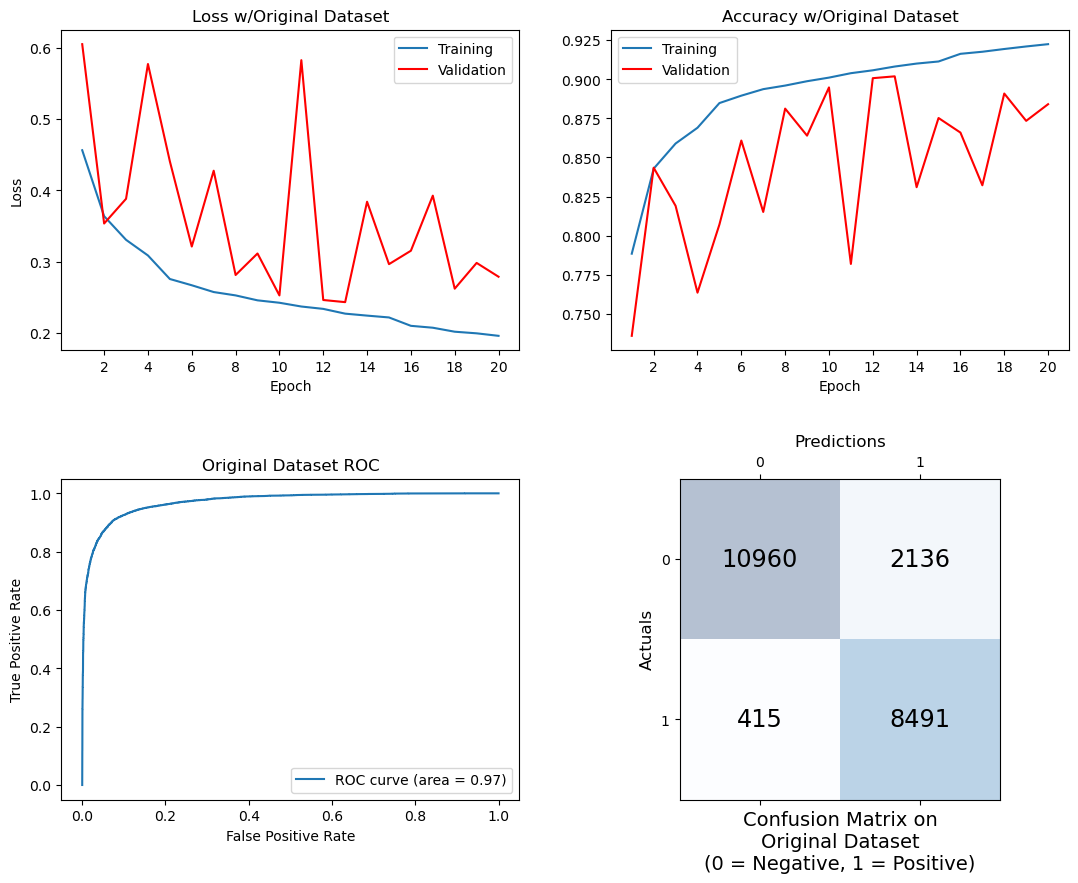

In [169]:
ORG_model.save(os.path.join("./Models/", "trad_mod_orig_data.h5"))

preds = ORG_model.predict(ORG_tfsValid)
actuals = []
for _, y in ORG_tfsValid:
    actuals.extend(list(y))
plotTrainingResults(ORG_history.history, actuals, preds, "Original Dataset")

### Augmenting the Image Dataset
I had previous experience with augmenting image datasets for identifying German road signs, so I was able to refer to some my earlier work regarding the technical details for some of the transformations.

There are several transformations available:
* Brightness
* Contrast
* Flip (horizontal and/or vertical)
* Rotation
* Shift (left/right, up/down)
* Skew
* Zoom (in or out)

Of these available transformations, Shift, Skew, and Zoom were not applied as these would either move a relevant pixel out of the center 32 pixel x 32 pixel area of interest or obscure it due to interpolation.

There was a possibility of a random rotation moving a pixel of iterest out the center 32 pixel x 32 pixel area, but I felt that was a chance worth taking for what might be a good result.

The **augmentImages** function defined earlier applied all of the remaining 4 transformations to the training images, creating 4 new images with these transformations applied and leaving the original image unchanged. This resulted in creating 5 times the number of images with labels, so now there were 1,100,125 images.  Of this 10% were still held for validating the model resulting in 110,012 images being set aside for validation and the model being trained on the remaining 990,113.

The increase in number of images did extend the training time, but this could be allowed to run overnight without human intervention or futher tuning.  Of note, the exact same model architecture from Model #1 was used with this larger dataset.

In [ ]:
#Augmentation of data and retraining
if recreateTrainDir:
    augmentImages(dirModelTrainNegative)
    augmentImages(dirModelTrainPositive)

AUG_tfdsTrain, AUG_tfsValid, AUG_model = buildStandardModel(batchSize = 64)
AUG_model.summary()
AUG_history = AUG_model.fit(AUG_tfdsTrain, validation_data = AUG_tfsValid, epochs = 20, callbacks = callbacks_list)
AUG_model.save(os.path.join("./Models/", "trad_mod_aug_data.h5"))


The results of using the augmented image dataset speak for themselves with improvement found across every measure:  

|  | Augmented | Original |
|---|---|---|
| Accuracy | 0.9562 | 0.8841 |
| Precision | 0.9384 | 0.7990 |
| Recall | 0.9546 | 0.9534 |
| Area Under ROC | 0.9905 | 0.9710 |

Additionally, the plots of the model state while it was training no longer show the dramatic dips and spikes in accuracy and loss respectively.

1719/1719 [==============================] - 37s 22ms/step


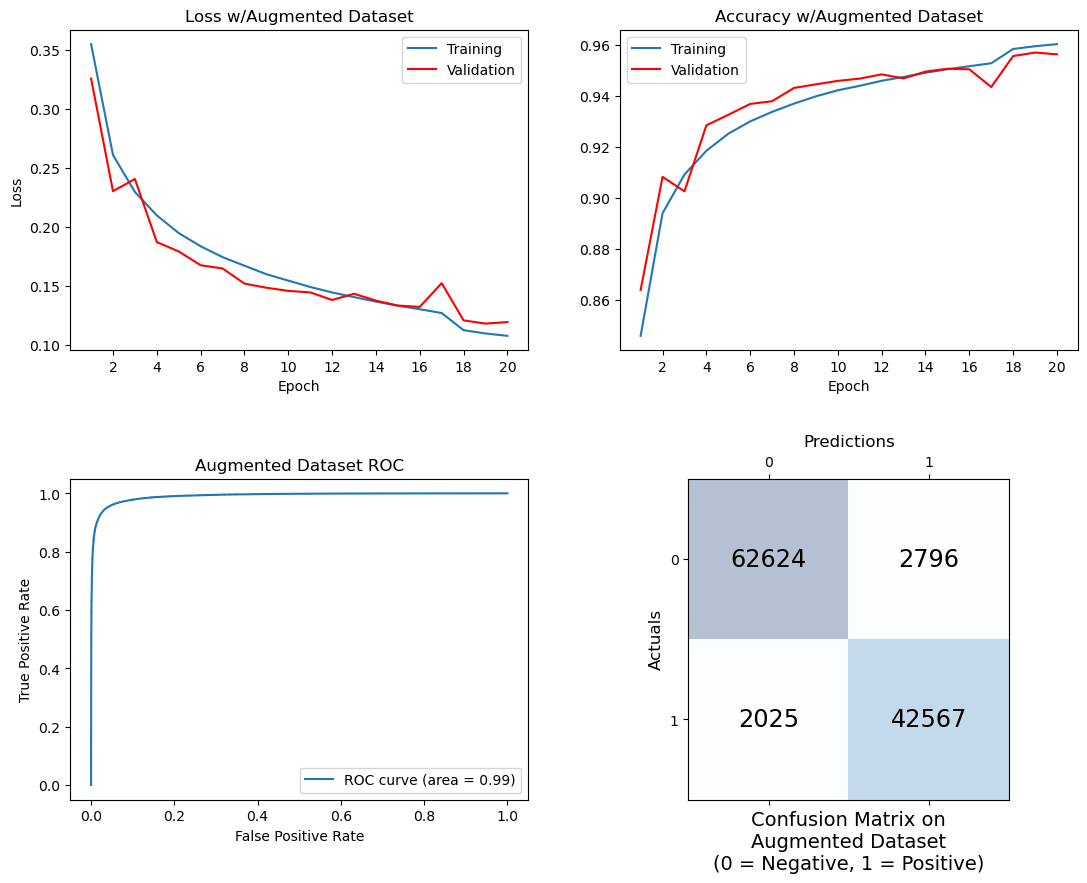

In [174]:
preds = AUG_model.predict(AUG_tfsValid)
actuals = []
for _, y in AUG_tfsValid:
    actuals.extend(list(y))
plotTrainingResults(AUG_history.history, actuals, preds, "Augmented Dataset")

### Submitting to Kaggle
With a model trained on the augmented image dataset, I decided to try submitting it to the Kaggle competition to see how well this model performed on the testing set of images.  

First step was again to convert the TIFF files in the testing dataset to the BMP format.

In [ ]:
submitDir = "TestingBMPs"
os.mkdir(submitDir)
dfTest = pd.read_csv(os.path.join(dirDLBase, "sample_submission.csv"))
for row in dfTest.itertuples():
    image = cv2.imread(os.path.join(dirDLTestBase, row.id + ".tif"), cv2.IMREAD_UNCHANGED)
    cv2.imwrite(os.path.join(submitDir, row.id + ".bmp"), image)


And the following cell creates the correctly formatted CSV file for submission to Kaggle resulted in a "Private Score" of 0.9038 and a "Public Score" of 0.9507. These were not as high as I had hoped for but were still better than many other submissions.  

However, I also wanted to try out one more model architecture...

In [354]:
def createSubmissionFile(submissionModel):
    tfdsTest = keras.utils.image_dataset_from_directory(
        submitDir,
        labels = None,
        label_mode = None,
        color_mode = 'rgb',
        batch_size = 64,
        image_size = (imgHeight, imgWidth),
        shuffle = False,
        seed = None,
        validation_split = None,
        subset = None
    )

    predictions = submissionModel.predict(tfdsTest)
    dictPred = dict((key, value) for (key, value) in zip(tfdsNewTest.file_paths, predictions[:, 0]))

    sampleList = list(dfTest.id)
    predictions = [dictPred[submitDir + "\\" + id + '.bmp'] for id in sampleList]

    dfSubmit = pd.DataFrame({'id':sampleList, 'label':predictions})
    dfSubmit.to_csv('submission.csv', header = True, index = False)
    print("Submission file created!")
    
createSubmissionFile(AUG_model)

Found 57458 files belonging to 1 classes.
898/898 [==============================] - 23s 26ms/step
Submission file created!


The next model architecture, [Tiny Darknet](https://pjreddie.com/darknet/tiny-darknet/), I discovered while exploring models on the web. I was intrigued by the design as it had no Dropout layers and promised both fast training and a small model size. I recreated the architecture using Keras and the model trained **twice** as fast on the _augmented_ dataset and resulted in an model that was 2/3 the HDF5 formated file size.


|  | Tiny Darknet | Augmented | Original |
|---|---|---|---|
| Accuracy | 0.9451 | 0.9562 | 0.8841 |
| Precision | 0.9169 | 0.9384 | 0.7990 |
| Recall | 0.9506 | 0.9546 | 0.9534 |
| Area Under ROC | 0.9815 | 0.9905 | 0.9710 |

Although in the end Tiny Darknet did not perform as well as the original model architecture, given that it trains much faster and has almost as good results could make it interesting for certain applications, such as those deployed on mobile devices.

In [352]:
TINY_model = Sequential()

_3by3 = (3, 3)
_1by1 = (1, 1)
pool_size = (2, 2)

input_shape = (imgHeight, imgWidth, 3)

TINY_model.add(Rescaling(1./255, input_shape=input_shape))

TINY_model.add(Conv2D(16, _3by3, activation='relu', padding = "same"))
TINY_model.add(MaxPooling2D(pool_size = pool_size))

TINY_model.add(Conv2D(32, _3by3, activation='relu', padding = "same"))
TINY_model.add(MaxPooling2D(pool_size = pool_size))

TINY_model.add(Conv2D(16, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(128, _3by3, activation='relu', padding = "same"))
TINY_model.add(Conv2D(16, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(128, _3by3, activation='relu', padding = "same"))
TINY_model.add(MaxPooling2D(pool_size = pool_size))

TINY_model.add(Conv2D(32, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(256, _3by3, activation='relu', padding = "same"))
TINY_model.add(Conv2D(32, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(256, _3by3, activation='relu', padding = "same"))
TINY_model.add(MaxPooling2D(pool_size = pool_size))

TINY_model.add(Conv2D(64, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(512, _3by3, activation='relu', padding = "same"))
TINY_model.add(Conv2D(64, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(512, _3by3, activation='relu', padding = "same"))
TINY_model.add(Conv2D(128, _1by1, activation='relu', padding = "same"))
TINY_model.add(Conv2D(1000, _1by1, activation='relu', padding = "same"))

TINY_model.add(keras.layers.AveragePooling2D(pool_size=(6, 6), strides=1, padding="valid"))
TINY_model.add(Flatten())

TINY_model.add(Dense(1, activation = "sigmoid"))

TINY_model.summary()

TINY_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = True), 
              metrics = METRICS)


Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_73 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_952 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_223 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_953 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_224 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_954 (Conv2D)         (None, 24, 24, 16)      

In [ ]:
TINY_history = TINY_model.fit(AUG_tfdsTrain, validation_data = AUG_tfsValid, epochs = 20, callbacks = callbacks_list)

Found 57458 files belonging to 1 classes.
898/898 [==============================] - 19s 21ms/step
Submission file created!
1719/1719 [==============================] - 37s 21ms/step


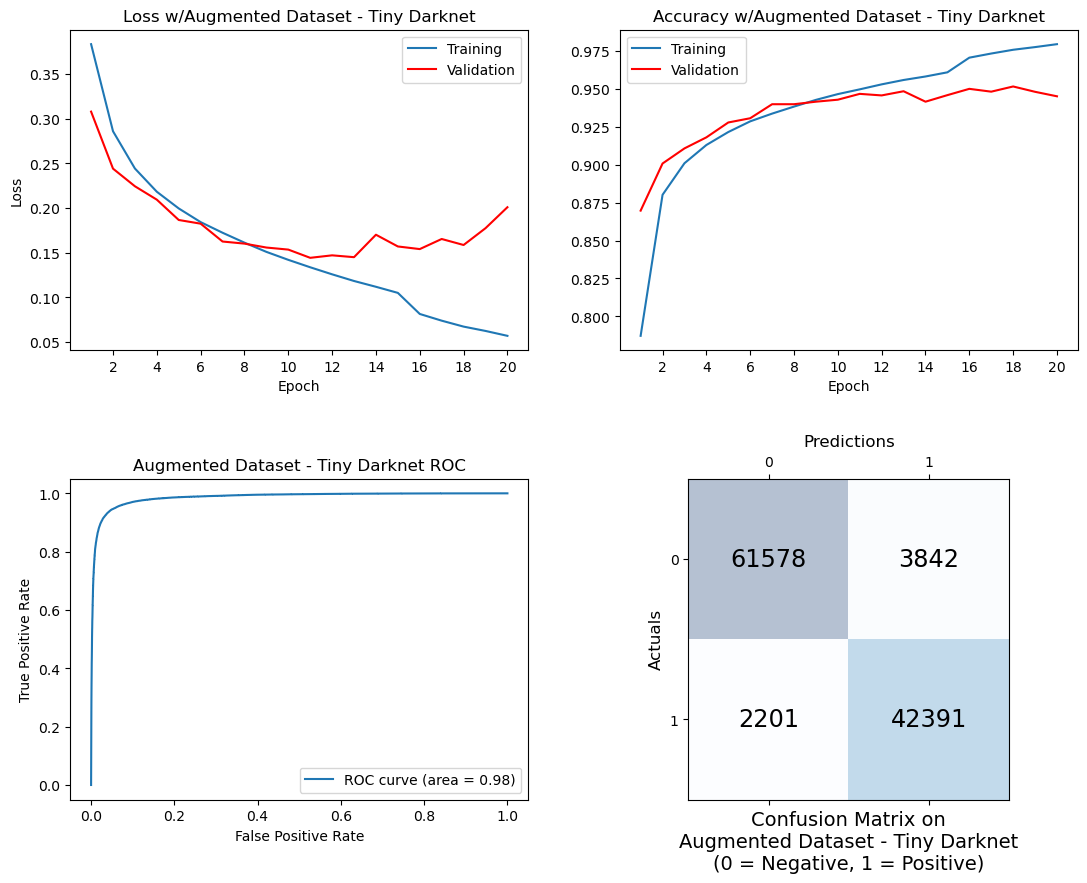

In [361]:
TINY_model.save(os.path.join("./Models/", "tiny_mod_aug_data.h5"))

createSubmissionFile(TINY_model)

preds = TINY_model.predict(AUG_tfsValid)
actuals = []
for _, y in AUG_tfsValid:
    actuals.extend(list(y))
plotTrainingResults(TINY_history.history, actuals, preds, "Augmented Dataset - Tiny Darknet")

### Conclusions
This project, although  time consuming, was very educational. The "traditional" architecture of covolutional layers followed by max pools and drop outs definitely performed the best.  

However, alternate model architecture still need to be examined as demonstrated by the relatively strong performance of Tiny Darknet (which could have been stopped after epoch 13!) with its fast training time and small size (which could be important if deploying to mobile devices).